In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.append(os.path.abspath('../src'))
from tarp_plus_plus import tarp_plus_plus

Here we define the Linear Regression Experiment from the Paper. We note that we must run the example multiple times otherwise the result in unreliable.

In [2]:
runs_probability = []
num_runs = 30
dim = 2
num_ground_truth = 10
num_models = 21

# Initialize arrays to store all m_truth and b_truth values
all_m_truths = np.zeros(num_ground_truth)
all_b_truths = np.zeros(num_ground_truth)


for run in range(num_runs):
    # probability = np.zeros((21, 10))
    # Truth is going to store the truth per each run
    truth = np.random.rand(num_ground_truth, dim)

    # Prob Matrix will store the probability with respect to each truth
    prob_matrix = np.random.rand(num_models, num_ground_truth, 100, dim)

    # Fill in truth with tuples (m, b) from Guassian Distribution
    for i in range(num_ground_truth):
        all_m_truths[i] = np.random.normal(-1, 1)
        all_b_truths[i] = np.random.normal(-5, 5)
    
    # Normalize all m_truth and b_truth values
    m_truths_normalized = (all_m_truths - np.min(all_m_truths)) / (np.max(all_m_truths) - np.min(all_m_truths))
    b_truths_normalized = (all_b_truths - np.min(all_b_truths)) / (np.max(all_b_truths) - np.min(all_b_truths))
    
    # Assign normalized values to truth array
    for i in range(num_ground_truth):
        truth[i] = np.array([m_truths_normalized[i], b_truths_normalized[i]])

    l_values = np.linspace(-5, 5, num_models)

    # Define the standard deviation values for the noise from 10 to 30 in logspace
    std_values = np.logspace(-40, -20, num_models)  # Log-spaced values from 10 to 100

    for i in range(len(truth)):
        A = np.vstack([np.linspace(0, 1, 100), np.ones(100)]).T
        x = truth[i]
        for j in range(len(l_values)):
            std_dev = std_values[j]
            # Generate Gaussian noise with the current standard deviation
            n = np.random.normal(l_values[j], std_dev, A.shape[0])            
            y = A @ x + n

            # Prior parameters
            mu_0 = np.zeros(2)
            Sigma_0 = np.eye(2)
            
            # Noise covariance matrix
            Sigma_n = std_dev**2 * np.eye(A.shape[0])
            
            # Compute the posterior covariance
            Sigma_post = np.linalg.inv(np.linalg.inv(Sigma_0) + A.T @ np.linalg.inv(Sigma_n) @ A)
            
            # Compute the posterior mean
            mu_post = Sigma_post @ (A.T @ np.linalg.inv(Sigma_n) @ y + np.linalg.inv(Sigma_0) @ mu_0)
            
            # Sample from the posterior
            samples = np.random.multivariate_normal(mu_post, Sigma_post, 100)
            
            # Store samples in the prob_matrix at index j, i
            prob_matrix[j, i] = samples

    probability = tarp_plus_plus(prob_matrix, truth, dim)

    runs_probability.append(probability)

In [3]:
model_expectations = np.empty((num_runs, len(l_values)))
model_log_probabilities = np.empty((num_runs, len(l_values)))

for i in range(num_runs):
    model_probabilities = runs_probability[i]
    # Normalize model_probabilities: 
    model_probabilities = model_probabilities / np.sum(model_probabilities, axis = 0)
    # Model Probab is 21 x 1000, sum only row 0 

    # Calculate the expectation value, row wise
    model_expectations[i] = np.average(model_probabilities, axis=1)
    # Calculate the log probability
    # model_log_probabilities[i] = np.sum(np.log(model_probabilities), axis=1)
    model_log_probabilities[i] = np.sum(np.log(model_probabilities), axis = 1)

# Average the model_expectations and model_log_probabilities
average_model_expectations = np.mean(model_expectations, axis=0)
average_model_log_probabilities = np.mean(model_log_probabilities, axis=0)

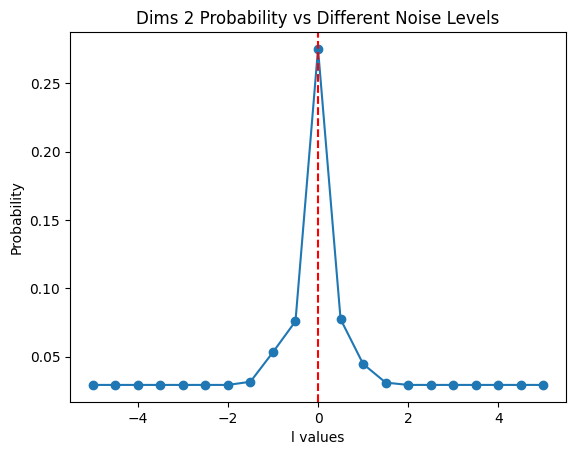

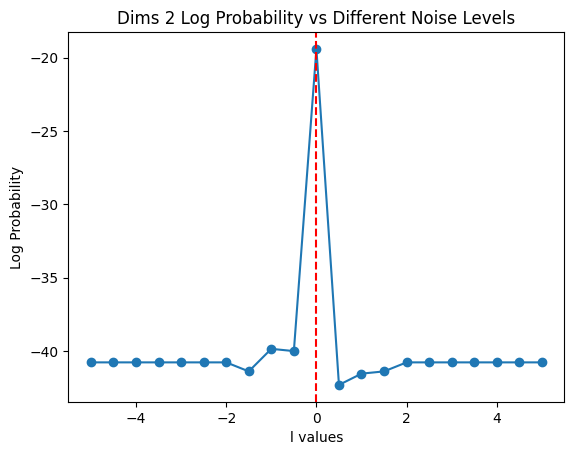

In [4]:
# Plot the average model expectations
plt.figure()
plt.plot(l_values, average_model_expectations, 'o-')
# Plot vertical line at x = 0
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("l values")
plt.ylabel("Probability")
plt.title(f"Dims 2 Probability vs Different Noise Levels")
plt.show()

# Plot the average model log probabilities
plt.figure()
plt.plot(l_values, average_model_log_probabilities, 'o-')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("l values")
plt.ylabel("Log Probability")
plt.title(f"Dims 2 Log Probability vs Different Noise Levels")
plt.show()